# 17-4 PH Stainless Steel - Natural Frequency

In [1]:
import numpy as np

import scipy # SciPy is a scientific computation library, SciPy stands for Scientific Python
from scipy import constants

import plotly.graph_objects as go
import mpmath
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator #sub-package ticker, will be used to customize the ticks of the axes
import xlrd
import pandas as pd

In [2]:
#Test this cell is just for storing helpful codes
#a = list(mpl.rcParams.keys) # lists  global parameters related to plot, 305 parameter
#print(a)

In [3]:
# Constants
Length1=0.008292  #Length of the first part (m)
Length2=0.0069378   #  length of the second part (m)
x1 =np.linspace(0,Length1,100) # coordinate system on part 1
x2 =np.linspace(0,Length2,100) # coordinate system on part 2
Breadth1=0.0042965 #width of the first part (m)
Breadth2=0.003  #width of the second part (m)
Thickness=0.0005  # thickness of the first part (m)
#
CrossSectionArea1=Breadth1*Thickness  # cross section area for part 1 (m2)
CrossSectionArea2=Breadth2*Thickness  # cross section area for part 1 (m2)
InertiaMoment1=Breadth1*(Thickness**3)/12  # second moment of the cross section area 1 (m4)
InertiaMoment2=Breadth2*(Thickness**3)/12  # second moment of the cross section area 2 (m4)
#
TestFrequency=20000  #Test Frequency in Hertz
HornAmplitude=20e-6  #this is the amplitute of the vibration
#
ElasticityModulus=1.4e11  # Modulus of elasticity, (Pa) # based on Material Datasheet from Markforged for As Sintered Condition-and this value needs to be confirmed/measured
#Density=7498  # Density (kg/m3) # based on Material Datasheet from Markforged for As-Sintered Condition is 96% (Relative Density and ASTM A564 H900 is 100%) for ASTM A564 H900  the density found 7.81, so 96% of 7.8=7.488 and this value needs to be confirmed/measured
#Density=7500.293  # Density (kg/m3) # based on dimension and weight measurment of a 3 dogbone specimens using bouyancy etc.
Density=7239  # Density (kg/m3) # based on dimension and weight measurment of a block

In [4]:
# Defining Required Functions
def Beta (AngularVelocity, CrossSectionA, InertiaMoment):
    Beta=((Density*(AngularVelocity**2)*CrossSectionA)/(ElasticityModulus*InertiaMoment))**0.25
    return Beta

def CoaficientMatrixFunction(Beta1, Beta2): # Beta1 and Beta2,
    CoaficientMatrixF=np.array([
    [1,0,1,0,0,0,0,0],
    [0,1,0,1,0,0,0,0],
    [0,0,0,0,(-1)*((Beta2)**2)*np.cos(Beta2*Length2),(-1)*((Beta2)**2)*np.sin(Beta2*Length2),((Beta2)**2)*np.cosh(Beta2*Length2),((Beta2)**2)*np.sinh(Beta2*Length2)],
    [0,0,0,0,((Beta2)**3)*np.sin(Beta2*Length2),(-1)*((Beta2)**3)*np.cos(Beta2*Length2),((Beta2)**3)*np.sinh(Beta2*Length2),((Beta2)**3)*np.cosh(Beta2*Length2)],
    [np.cos(Beta1*Length1),np.sin(Beta1*Length1),np.cosh(Beta1*Length1),np.sinh(Beta1*Length1),-1,0,-1,0],
    [(-1)*Beta1*np.sin(Beta1*Length1),Beta1*np.cos(Beta1*Length1),Beta1*np.sinh(Beta1*Length1),Beta1*np.cosh(Beta1*Length1),0,(-1)*Beta2,0,(-1)*Beta2],
    [(-1)*Breadth1*((Beta1)**2)*np.cos(Beta1*Length1),-Breadth1*((Beta1)**2)*np.sin(Beta1*Length1),Breadth1*((Beta1)**2)*np.cosh(Beta1*Length1),Breadth1*((Beta1)**2)*np.sinh(Beta1*Length1),Breadth2*((Beta2)**2),0,(-1)*Breadth2*((Beta2)**2),0],
    [Breadth1*((Beta1)**3)*np.sin(Beta1*Length1),(-1)*Breadth1*((Beta1)**3)*np.cos(Beta1*Length1),Breadth1*((Beta1)**3)*np.sinh(Beta1*Length1),Breadth1*((Beta1)**3)*np.cosh(Beta1*Length1),0,Breadth2*((Beta2)**3),0,(-1)*Breadth2*((Beta2)**3)],
    ])
    return CoaficientMatrixF

def AnswerMatrixFunction(HAmplitude):
    AnswerM=np.array([
    [HAmplitude],
    [0],
    [0],
    [0],
    [0],
    [0],
    [0],
    [0],
    ])
    return AnswerM

def DeflectionFunction (C1, C2, C3, C4, DBeta, Location):
    Deflection=C1*np.cos(DBeta*Location)+C2*np.sin(DBeta*Location)+C3*np.cosh(DBeta*Location)+C4*np.sinh(DBeta*Location)
    return Deflection

def InternalBendingMomentFunction(C1, C2, C3, C4, InertiaMoment, DBeta, Location):
    BendingMoment= ElasticityModulus*InertiaMoment*(DBeta**2)*(-C1*np.cos(DBeta*Location)-C2*np.sin(DBeta*Location)+C3*np.cosh(DBeta*Location)+C4*np.sinh(DBeta*Location))
    return BendingMoment

def MaxNormalStress (InternalMoment, InertiaMoment):
    NStress=(InternalMoment*(Thickness/2))/InertiaMoment
    return NStress

def TempMaxNormalStress (InternalMoment, InertiaMoment,Thick):
    TempNStress=(InternalMoment*(Thick/2))/InertiaMoment
    return TempNStress

# Natural Frequencies Calculation

In [5]:
TestingFrequency=[]
DeterminantMatrix=[]
NaturalFrequency=[]
for i in range(0,3000,1): 
    TestingFrequency.append(1000+i*10)  # testing frequency
    Omega=2*(np.pi)*float(TestingFrequency[i])
    beta1=Beta(Omega,CrossSectionArea1,InertiaMoment1)
    beta2=Beta(Omega,CrossSectionArea2,InertiaMoment2)
    CoaficientMatrix=CoaficientMatrixFunction(beta1, beta2)
    DeterminantMatrix.append(np.linalg.det(CoaficientMatrix))
    if i>1 and DeterminantMatrix[i]*DeterminantMatrix[i-1]<0:
        NaturalFrequency.append((TestingFrequency[i]+TestingFrequency[i-1])/2)
        
print (NaturalFrequency)
#plt.plot(TestingFrequency,DeterminantMatrix)
#plt.show

[1795.0, 9745.0, 26895.0]


<function matplotlib.pyplot.show(close=None, block=None)>

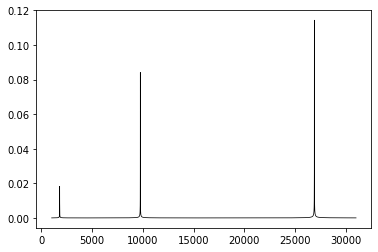

In [6]:
EndPointDeflection = []
TestingFrequency = []
EndPointDeflection1 = []
for i in range(0, 6000, 1):
    TestingFrequency.append(1005 + 0.5*i * 10)  # testing frequency
    Omega = 2 * (np.pi) * float(TestingFrequency[i])
    beta1=Beta(Omega,CrossSectionArea1,InertiaMoment1)
    beta2=Beta(Omega,CrossSectionArea2,InertiaMoment2)
    CoaficientMatrix=CoaficientMatrixFunction(beta1, beta2)
    AnswerMatrix=AnswerMatrixFunction(HornAmplitude)
    ConstantsMatrix=np.linalg.solve(CoaficientMatrix,AnswerMatrix)
    C11 = ConstantsMatrix[0][0]
    C21 = ConstantsMatrix[1][0]
    C31 = ConstantsMatrix[2][0]
    C41 = ConstantsMatrix[3][0]
    C12 = ConstantsMatrix[4][0]
    C22 = ConstantsMatrix[5][0]
    C32 = ConstantsMatrix[6][0]
    C42 = ConstantsMatrix[7][0]
    EndPointDeflection.append(abs(DeflectionFunction (C12, C22, C32, C42, beta2, Length2)))

AmpVSFrqPlot=plt.plot(TestingFrequency, EndPointDeflection, color="black", linewidth=0.75)

plt.show

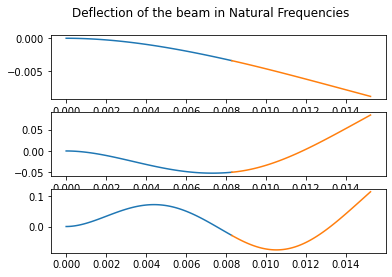

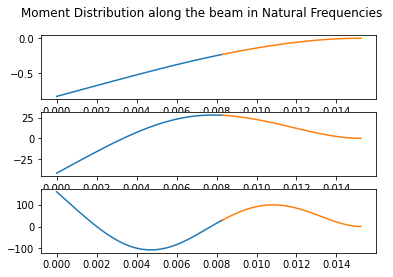

In [7]:
fig1, DeflectionPlots = plt.subplots(3)
fig1.suptitle('Deflection of the beam in Natural Frequencies ')
fig2, MomentPlots = plt.subplots(3)
fig2.suptitle('Moment Distribution along the beam in Natural Frequencies ')
Counter=0

for i in NaturalFrequency:
    Omega=2*np.pi*i
    beta1=Beta(Omega,CrossSectionArea1,InertiaMoment1)
    beta2=Beta(Omega,CrossSectionArea2,InertiaMoment2)
    CoaficientMatrix=CoaficientMatrixFunction(beta1, beta2)
    AnswerMatrix=AnswerMatrixFunction(HornAmplitude)
    ConstantsMatrix=np.linalg.solve(CoaficientMatrix,AnswerMatrix)
    
    C11=ConstantsMatrix[0][0]
    C21=ConstantsMatrix[1][0]
    C31=ConstantsMatrix[2][0]
    C41=ConstantsMatrix[3][0]
    C12=ConstantsMatrix[4][0]
    C22=ConstantsMatrix[5][0]
    C32=ConstantsMatrix[6][0]
    C42=ConstantsMatrix[7][0]

    W1=DeflectionFunction (C11, C21, C31, C41, beta1, x1)
    W2=DeflectionFunction (C12, C22, C32, C42, beta2, x2)


    M1=InternalBendingMomentFunction(C11, C21, C31, C41, InertiaMoment1, beta1, x1)
    M2=InternalBendingMomentFunction(C12, C22, C32, C42, InertiaMoment2, beta2, x2)
    #print(Counter)
    DeflectionPlots[Counter].plot(x1,W1)
    DeflectionPlots[Counter].plot(x2+Length1,W2)
    MomentPlots[Counter].plot(x1,M1)
    MomentPlots[Counter].plot(x2+Length1,M2)
    Counter=Counter+1

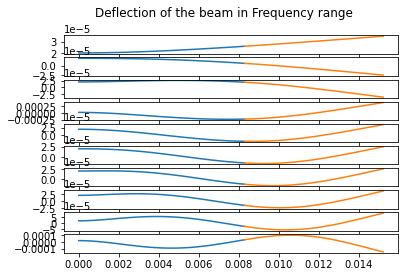

In [8]:
fig3, DeflectionPlots = plt.subplots(10)
#fig3, DeflectionPlots = plt.subplots(10,10)
fig3.suptitle('Deflection of the beam in Frequency range ')
#fig, MomentPlots = plt.subplots(10)
Counter=0
#Counter1=0
#Counter2=0
TestingFrequency = []

for i in range(0, 10, 1):
    TestingFrequency.append(1000 + i * 3000)  # testing frequency
    Omega = 2 * (np.pi) * float(TestingFrequency[i])
    beta1=Beta(Omega,CrossSectionArea1,InertiaMoment1)
    beta2=Beta(Omega,CrossSectionArea2,InertiaMoment2)
    CoaficientMatrix=CoaficientMatrixFunction(beta1, beta2)
    AnswerMatrix=AnswerMatrixFunction(HornAmplitude)
    ConstantsMatrix=np.linalg.solve(CoaficientMatrix,AnswerMatrix)
    
    C11=ConstantsMatrix[0][0]
    C21=ConstantsMatrix[1][0]
    C31=ConstantsMatrix[2][0]
    C41=ConstantsMatrix[3][0]
    C12=ConstantsMatrix[4][0]
    C22=ConstantsMatrix[5][0]
    C32=ConstantsMatrix[6][0]
    C42=ConstantsMatrix[7][0]

    W1=DeflectionFunction (C11, C21, C31, C41, beta1, x1)
    W2=DeflectionFunction (C12, C22, C32, C42, beta2, x2)

    DeflectionPlots[Counter].plot(x1,W1)
    DeflectionPlots[Counter].plot(x2+Length1,W2)
    
    
    #DeflectionPlots[Counter1,Counter2].plot(x1,W1)
    #DeflectionPlots[Counter1,Counter2].plot(x2+Length1,W2)
    
    
    # Counter1=Counter1+1
   # if 
    

    Counter=Counter+1

# 17-4 PH Stainless Steel - Shape Extraction

The Min Value of Beam Deflection is:  -17.652534491311595  Micro meter and it happens in part2
The position for Max Vertical Displacement is:  [9.83373333]  mm from fixed end
The position for Max Vertical Displacement is:  [5.39606667]  mm from free end
The Max Value of Beam Deflection is:  27.20460918818381  Micro meter and it happens in part2
The Deflection Amplitude at the free end point is:  27.20460918818381  Micro meter
The Deflection Amplitude at about 1mm away from the free end point is:  15.41362677170002  Micro meter


<function matplotlib.pyplot.show(close=None, block=None)>

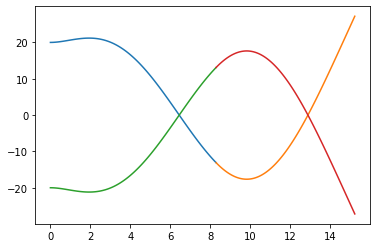

In [9]:
Omega=2*np.pi*TestFrequency
beta1=Beta(Omega,CrossSectionArea1,InertiaMoment1)
beta2=Beta(Omega,CrossSectionArea2,InertiaMoment2)
CoaficientMatrix=CoaficientMatrixFunction(beta1, beta2)
AnswerMatrix=AnswerMatrixFunction(HornAmplitude)
ConstantsMatrix=np.linalg.solve(CoaficientMatrix,AnswerMatrix)

C11=ConstantsMatrix[0][0]
C21=ConstantsMatrix[1][0]
C31=ConstantsMatrix[2][0]
C41=ConstantsMatrix[3][0]
C12=ConstantsMatrix[4][0]
C22=ConstantsMatrix[5][0]
C32=ConstantsMatrix[6][0]
C42=ConstantsMatrix[7][0]

W1=DeflectionFunction (C11, C21, C31, C41, beta1, x1)
W2=DeflectionFunction (C12, C22, C32, C42, beta2, x2)

M1=InternalBendingMomentFunction(C11, C21, C31, C41, InertiaMoment1, beta1, x1)
M2=InternalBendingMomentFunction(C12, C22, C32, C42, InertiaMoment2, beta2, x2)

S1=MaxNormalStress (M1, InertiaMoment1)
S2=MaxNormalStress (M2, InertiaMoment2)

MinW2=np.min(W2)
MinW2=MinW2*1000000
MaxW2=np.max(W2)
MaxW2=MaxW2*1000000
MinW1=np.min(W1)
MinW1=MinW1*1000000
MaxW1=np.max(W1)
MaxW1=MaxW1*1000000

if MinW2<MinW1:    
    print("The Min Value of Beam Deflection is: ",MinW2," Micro meter and it happens in part2")
    print("The position for Max Vertical Displacement is: ",(x2[np.where(W2==np.min(W2))[0]]+Length1)*1000," mm from fixed end")
    print("The position for Max Vertical Displacement is: ",(Length2-x2[np.where(W2==np.min(W2))[0]])*1000," mm from free end")
else:
    print("The Min Value of Beam Deflection is: ",MinW1," Micro meter and it happens in part1")
    print("The position for Max Vertical Displacement is: ",(x1[np.where(W1==np.min(W1))[0]])*1000," mm from fixed end")
    print("The position for Max Vertical Displacement is: ",(Length2+(Length1-x1[np.where(W1==np.min(W1))[0]]))*1000," mm from free end")
if MaxW2>MaxW1:
    print("The Max Value of Beam Deflection is: ",MaxW2," Micro meter and it happens in part2")
else:
    print("The Max Value of Beam Deflection is: ",MaxW1," Micro meter and it happens in part1")

#Gives the displacement aplitude of the free end of the beam
print("The Deflection Amplitude at the free end point is: ",W2[99]*1000000," Micro meter") # at the free end
print("The Deflection Amplitude at about 1mm away from the free end point is: ",W2[85]*1000000," Micro meter") # about 1mm away from the free end


W11=-W1
W22=-W2

plt.plot(x1*1000,W1*1000000)
plt.plot((x2+Length1)*1000,W2*1000000)
plt.plot(x1*1000,W11*1000000)
plt.plot((x2+Length1)*1000,W22*1000000)
plt.show

In [10]:
# This cell is to compare the results of the simiulation with the analytical solution
#XValues=[]
#YDefValues=[]

#FileLocation = ("C:/Users/me-admin/Desktop/YDeformation.xlsx") #Location for Excel file which has the simulation results
#FileLocation = ("C:/Users/me-admin/OneDrive - Louisiana State University/8-My Publications/5-17-4 Additive Paper/2-Python Code/YDeformation.xlsx") #Location for Excel file which has the simulation results
#Just put r before your normal string it converts normal string to raw string:
# or FileLocation = (r"C:\Users\me-admin\Desktop\YDeformation.xlsx")
#SimulationWorkbook = xlrd.open_workbook(FileLocation)
#sheet = SimulationWorkbook.sheet_by_index(0)

#for i in range(2,sheet.nrows,1):
    #print(sheet.cell_value(i, 1))
    #print(sheet.cell_value(i, 2))
#    XValues.append(sheet.cell_value(i, 1))
#    YDefValues.append(sheet.cell_value(i, 2))
#    YDefValues[i-2]=YDefValues[i-2]*1000
    
#plt.plot(XValues,YDefValues,'b--',label='FEM Simulation', linewidth=4)

#plt.plot(x1*1000,W1*1000000,'r.',label='FEM Simulation', linewidth=2)
#plt.plot((x2+Length1)*1000,W2*1000000,'r.',linewidth=2)

#plt.title("Comparing Deflections from FEM and Analytical Solution", fontsize = 10)
#plt.xlabel("Specimen length (mm)", fontsize = 10)
#plt.ylabel("Horn's Tip Amplitude (Micro meter)", fontsize = 10)
#plt.tick_params(axis='both', labelsize = 13)

#plt.show


The Min Value of Beam Internal Bending Moment is:  -0.0155110257413173  Nm and it happens in part1
The position for Min Value of Beam Internal Bending Moment is:  [3.35030303]  mm from fixed end
The position for Min Value of Beam Internal Bending Moment is:  [11.87949697]  mm from free end
The Max Value of Beam Internal Bending Moment is:  0.018012091776146183  Nm and it happens in part2
The position for Max Value of Beam Internal Bending Moment is:  [10.0439697]  mm from fixed end
The position for Max Value of Beam Internal Bending Moment is:  [5.1858303]  mm from free end


<function matplotlib.pyplot.show(close=None, block=None)>

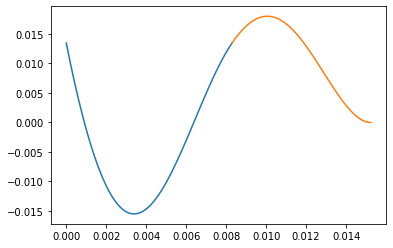

In [11]:
MinM1=np.min(M1)
MaxM1=np.max(M1)
MinM2=np.min(M2)
MaxM2=np.max(M2)

if MinM2<MinM1:    
    print("The Min Value of Beam Internal Bending Moment is: ",MinM2," Nm and it happens in part2")
    print("The position for Min Value of Beam Internal Bending Moment is: ",(x2[np.where(M2==np.min(M2))[0]]+Length1)*1000," mm from fixed end")
    print("The position for Min Value of Beam Internal Bending Moment is: ",(Length2-x2[np.where(M2==np.min(M2))[0]])*1000," mm from free end")
else:
    print("The Min Value of Beam Internal Bending Moment is: ",MinM1," Nm and it happens in part1")
    print("The position for Min Value of Beam Internal Bending Moment is: ",(x1[np.where(M1==np.min(M1))[0]])*1000," mm from fixed end")
    print("The position for Min Value of Beam Internal Bending Moment is: ",(Length2+(Length1-x1[np.where(M1==np.min(M1))[0]]))*1000," mm from free end")

if MaxM2>MaxM1:    
    print("The Max Value of Beam Internal Bending Moment is: ",MaxM2," Nm and it happens in part2")
    print("The position for Max Value of Beam Internal Bending Moment is: ",(x2[np.where(M2==np.max(M2))[0]]+Length1)*1000," mm from fixed end")
    print("The position for Max Value of Beam Internal Bending Moment is: ",(Length2-x2[np.where(M2==np.max(M2))[0]])*1000," mm from free end")
else:
    print("The Max Value of Beam Internal Bending Moment is: ",MaxM1," Nm and it happens in part1")
    print("The position for Max Value of Beam Internal Bending Moment is: ",(x1[np.where(M1==np.max(M1))[0]])*1000," mm from fixed end")
    print("The position for Max Value of Beam Internal Bending Moment is: ",(Length2+(Length1-x1[np.where(M1==np.max(M1))[0]]))*1000," mm from free end")


plt.plot(x1,M1)
plt.plot(x2+Length1,M2)
plt.show

In [12]:
MaxS1 = np.max(np.abs(S1))
MaxS2 = np.max(np.abs(S2))
print("The Max Value of Normal Stress in Part1 is: ", MaxS1 / 1000000, " Mpa")
print("The Max Value of Normal Stress in Part2 is: ", MaxS2 / 1000000, " Mpa")
print("The position for Max Value of S1 is: ",(x1[np.where(abs(S1) == np.max(np.abs(S1)))[0]]) * 1000," mm from fixed end")
print("The position for Max Value of S2 is: ",(x2[np.where(abs(S2) == np.max(np.abs(S2)))[0]] + Length1) * 1000," mm from fixed end and:", (Length2-x2[np.where(abs(S2) == np.max(np.abs(S2)))[0]]) * 1000," mm from the free end")

#plt.plot(x1, -S1)
#plt.plot(x2 + Length1, S2)
#plt.show

The Max Value of Normal Stress in Part1 is:  86.64369086270574  Mpa
The Max Value of Normal Stress in Part2 is:  144.09673420916948  Mpa
The position for Max Value of S1 is:  [3.35030303]  mm from fixed end
The position for Max Value of S2 is:  [10.0439697]  mm from fixed end and: [5.1858303]  mm from the free end


    Hrn tip Amp(M m)  Def in 0.5mm to free end(M m)  Max. N Stress(MPa)
0               10.0                      10.589533           72.048367
1               11.0                      11.648486           79.253204
2               12.0                      12.707439           86.458041
3               13.0                      13.766392           93.662877
4               14.0                      14.825346          100.867714
5               15.0                      15.884299          108.072551
6               16.0                      16.943252          115.277387
7               17.0                      18.002205          122.482224
8               18.0                      19.061159          129.687061
9               19.0                      20.120112          136.891897
10              20.0                      21.179065          144.096734
11              21.0                      22.238018          151.301571
12              22.0                      23.296972          158

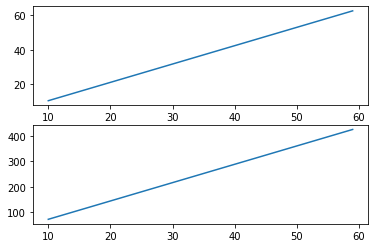

In [13]:
fig, HornAmpStudyPts = plt.subplots(2)
TestingHornAmplitude=[]
#MinW2=[]
MaxS2=[]
W2EndPoint=[]

for i in range(0, 50, 1):
    TestingHornAmplitude.append(10e-6 + i * (1e-6))  # testing Horn Amplitude
    Omega=2*np.pi*TestFrequency
    beta1=Beta(Omega,CrossSectionArea1,InertiaMoment1)
    beta2=Beta(Omega,CrossSectionArea2,InertiaMoment2)
    CoaficientMatrix=CoaficientMatrixFunction(beta1, beta2)
    AnswerMatrix=AnswerMatrixFunction(TestingHornAmplitude[i])
    ConstantsMatrix=np.linalg.solve(CoaficientMatrix,AnswerMatrix)
    C11=ConstantsMatrix[0][0]
    C21=ConstantsMatrix[1][0]
    C31=ConstantsMatrix[2][0]
    C41=ConstantsMatrix[3][0]
    C12=ConstantsMatrix[4][0]
    C22=ConstantsMatrix[5][0]
    C32=ConstantsMatrix[6][0]
    C42=ConstantsMatrix[7][0]

    W1=DeflectionFunction (C11, C21, C31, C41, beta1, x1)
    W2=DeflectionFunction (C12, C22, C32, C42, beta2, x2)
    
    EndPointX2=Length2-0.0005  # Location of the laser point, 0.5mm from the free end of the specimen
    W2EndPoint.append(DeflectionFunction (C12, C22, C32, C42, beta2, EndPointX2)*1000000)
    #W2EndPoint=W2EndPoint*1000000

    #M1=InternalBendingMomentFunction(C11, C21, C31, C41, InertiaMoment1, beta1, x1)
    M2=InternalBendingMomentFunction(C12, C22, C32, C42, InertiaMoment2, beta2, x2)

    #S1=MaxNormalStress (M1, InertiaMoment1)
    S2=MaxNormalStress (M2, InertiaMoment2)

    MaxS2.append(np.max(np.abs(S2))/1000000)

    #MinW2.append(np.min(W2))

    TestingHornAmplitude[i]=TestingHornAmplitude[i]*1000000

#HornAmpStudyPts[0].plot(TestingHornAmplitude,MinW2)
HornAmpStudyPts[0].plot(TestingHornAmplitude,W2EndPoint)
HornAmpStudyPts[1].plot(TestingHornAmplitude,MaxS2)
plt.show

MyTable = {"Hrn tip Amp(M m)" : TestingHornAmplitude ,"Def in 0.5mm to free end(M m)": W2EndPoint,"Max. N Stress(MPa)": MaxS2}
df = pd.DataFrame(MyTable, columns=["Hrn tip Amp(M m)","Def in 0.5mm to free end(M m)","Max. N Stress(MPa)"])
print(df)


#Length2=0.0069378   #  length of the second part (m)

In [15]:

TestingHornAmplitude=[]
TempThickness=[]

i, j = 36, 51;
MaxS2=[[0 for x in range(i)] for y in range(j)]
#print(MaxS2)


for i in range(0, 51, 1):
    TestingHornAmplitude.append(10e-6 + i * (1e-6))  # testing Horn Amplitude
    Omega=2*np.pi*TestFrequency
    #print("Horn's Amp is: ",round(TestingHornAmplitude[i]*1000000,2))
    for j in range(0,36,1):
        TempThickness.append(0.000490+ j * (2e-6))  # thickness of the first part (m)
        TempCrossSectionArea1=Breadth1*TempThickness[j]  # cross section area for part 1 (m2)
        TempCrossSectionArea2=Breadth2*TempThickness[j]  # cross section area for part 1 (m2)
        TempInertiaMoment1=Breadth1*(TempThickness[j]**3)/12  # second moment of the cross section area 1 (m4)
        TempInertiaMoment2=Breadth2*(TempThickness[j]**3)/12  # second moment of the cross section area 2 (m4)
        Tempbeta1=Beta(Omega,TempCrossSectionArea1,TempInertiaMoment1)
        Tempbeta2=Beta(Omega,TempCrossSectionArea2,TempInertiaMoment2)
        CoaficientMatrix=CoaficientMatrixFunction(Tempbeta1, Tempbeta2)
        AnswerMatrix=AnswerMatrixFunction(TestingHornAmplitude[i])
        ConstantsMatrix=np.linalg.solve(CoaficientMatrix,AnswerMatrix)
        C11=ConstantsMatrix[0][0]
        C21=ConstantsMatrix[1][0]
        C31=ConstantsMatrix[2][0]
        C41=ConstantsMatrix[3][0]
        C12=ConstantsMatrix[4][0]
        C22=ConstantsMatrix[5][0]
        C32=ConstantsMatrix[6][0]
        C42=ConstantsMatrix[7][0]

        W1=DeflectionFunction (C11, C21, C31, C41, Tempbeta1, x1)
        W2=DeflectionFunction (C12, C22, C32, C42, Tempbeta2, x2)
 
        M1=InternalBendingMomentFunction(C11, C21, C31, C41, TempInertiaMoment1, Tempbeta1, x1)
        M2=InternalBendingMomentFunction(C12, C22, C32, C42, TempInertiaMoment2, Tempbeta2, x2)

        S1=TempMaxNormalStress (M1, TempInertiaMoment1,TempThickness[j])
        S2=TempMaxNormalStress (M2, TempInertiaMoment2,TempThickness[j])

        MaxS2[i][j]=np.max(np.abs(S2))/1000000
        MaxS2[i][j]=round(MaxS2[i][j],2)
        
        #print(TempThickness[j])
        #print('i is: ',i,' and j is: ', j)
        #print(round(TempThickness[j]*1000,3)," mm")
        #print(MaxS2[j])
        #print(round(MaxS2[i][j],2), " Mpa")

    TestingHornAmplitude[i]=TestingHornAmplitude[i]*1000000






df = pd.DataFrame(MaxS2)
writer = pd.ExcelWriter('AmpThickStress.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

